## Условие задачи

Яндекс.Музыка проводит офлайн-фестиваль самых популярных исполнителей жанра техно. Чтобы привлечь пользователей на мероприятие, маркетолог Иван должен разослать email пользователям Музыки. Отправка одного письма стоит 10 рублей, а цена билета составляет 700 рублей. Как бы вы посоветовали Ивану сформировать выборку для отправки, учитывая логи прослушиваний пользователей Яндекс.Музыки?

Обозначения в таблице:

- audition_id – ID прослушивания в логе

- utc_audition_start_dttm – дата начала прослушивания в формате YYYY-MM-DD hh:mm:ss

- utc_audition_end_dttm – дата окончания прослушивания в формате YYYY-MM-DD hh:mm:ss

- user_id – ID пользователя Яндекс.Музыки

- track_id – ID трека Яндекс.Музыки

- track_duration – продолжительность трека в секундах

- track_genre – жанр трека

## Загрузка и предобработка

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# загрузим датасет
df = pd.read_csv('music_data.csv', index_col=0)
df.head()

,audition_id,track_duration,track_genre,track_id,user_id,utc_audition_end_dttm,utc_audition_start_dttm
0,3fecd60bf5564de7bb0064335f482b4d,336.629082,RAP,efd614e5-239a-418e-b39c-181b43719b62,a72d73ea124840698aa8,2021-02-28T12:32:10.776000Z,2021-02-28T12:31:01.865000Z
1,8ae1703df8354ee6b8d39ce2ceae4508,428.797846,VOCAL,d4697e6e-698a-41e8-8e15-ec890c94751e,066cc9287de340f281ba,2021-01-19T12:13:43.369000Z,2021-01-19T12:12:48.185000Z
2,44383125d98a4d939e7f294602674fc6,463.467143,METAL,e006afab-c832-4d07-8cd0-7d4a9c2aabe8,95ed23b52b104f66b4b1,2021-02-27T19:53:57.143000Z,2021-02-27T19:52:42.470000Z
3,a90b74992c9f4046a68935cb83ced7ee,323.746259,HARDROCK,c2ea845c-fcba-480a-b41a-d58bf9493375,b0a6dcec6f604b50b37e,2021-02-24T01:51:44.526000Z,2021-02-24T01:46:25.549000Z
4,0d98a88fba0a4dc3bb0444089a0ce16b,316.888403,POP,ad68738c-2a38-4e0f-910a-71bb0aa0a0c0,6788b1c78a724de488c9,2020-12-24T05:04:32.855000Z,2020-12-24T05:00:09.645000Z


Для начала подробнее рассмотрим данные и выделим особенности выборки.

In [9]:
df.shape

(842397, 7)

In [10]:
# все прослушивания в датасете уникальны
df.audition_id.count() - df.audition_id.nunique()

0

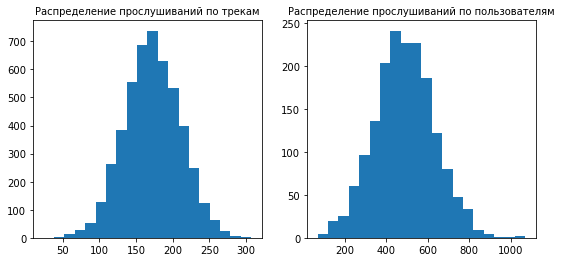

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

df.groupby('track_id').track_id.count().hist(bins=20, ax=ax1, grid=False)
df.groupby('user_id').track_id.count().hist(bins=20, ax=ax2, grid=False)

ax1.set_title('Распределение прослушиваний по трекам', size=10)
ax2.set_title('Распределение прослушиваний по пользователям', size=10)

plt.show()

Количество прослушиваний по пользователям и трекам распределено нормально.

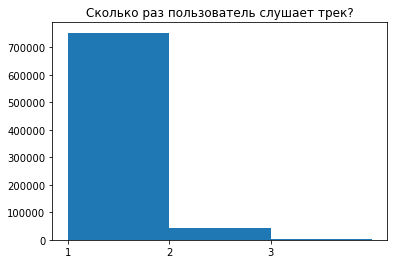

In [12]:
df.groupby(['user_id', 'track_id']).track_id.count().hist(bins=3, grid=False)
plt.title('Сколько раз пользователь слушает трек?')
plt.xticks(range(1, 4))
plt.show()

Обычно пользователи прослушивают трек не более одного раза.

In [14]:
df.groupby(['user_id', 'track_id']).track_id.count().describe().round(2)

count    796565.00
mean          1.06
std           0.24
min           1.00
25%           1.00
50%           1.00
75%           1.00
max           4.00
Name: track_id, dtype: float64

В среднем пользователь слушает трек 1.06 раз.

In [15]:
# приведем начало и конец прослушивания в формат datetime
df['audition_end'] = pd.to_datetime(df.utc_audition_end_dttm)
df['audition_start'] = pd.to_datetime(df.utc_audition_start_dttm)
# посчитаем процент от длины трека, который пользователь прослушал
df['listened'] = ((df.audition_end - df.audition_start).dt.total_seconds() / df.track_duration)

In [16]:
# выделим id пользователя, жанр трека и прослушанную долю в отдельный датафрейм
df_new = df.loc[:, ['user_id', 'track_genre', 'listened']]
df_new.head()

,user_id,track_genre,listened
0,a72d73ea124840698aa8,RAP,0.204709
1,066cc9287de340f281ba,VOCAL,0.128695
2,95ed23b52b104f66b4b1,METAL,0.161118
3,b0a6dcec6f604b50b37e,HARDROCK,0.985269
4,6788b1c78a724de488c9,POP,0.830608


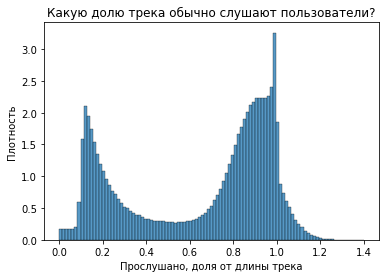

In [17]:
sns.histplot(data=df_new, x='listened', stat='density')
plt.title('Какую долю трека обычно слушают пользователи?')
plt.xlabel('Прослушано, доля от длины трека')
plt.ylabel('Плотность')
plt.show()

Наблюдаем бимодальное распределение - пользователь либо слушает трек до конца, либо сразу выключает.

In [18]:
df_new.listened.describe().round(2)

count    842397.00
mean          0.65
std           0.34
min           0.00
25%           0.27
50%           0.81
75%           0.93
max           1.40
Name: listened, dtype: float64

Некоторые треки прослушаны более, чем на 100%. Есть 3 гипотезы, почему так произошло:
- Пользователь перематывал трек назад в процессе прослушивания,
- Пользователь ставил трек на паузу во время прослушивания,
- В данных о начале и конце прослушивания есть ошибки.

В первых двух случаях можно сказать, что пользователю скорее нравится трек. Чем дольше пользователь слушает трек, тем выше вероятность того, что он поставит его на паузу.

Но на всякий случай уберем такие наблюдения из данных до выяснения обстоятельств.

In [19]:
print(df_new.query('listened > 1.0').count().listened)
df_new = df_new.query('listened <= 1.0')

62029


In [20]:
# предположим, что пользователю понравился трек, если прослушано более 70%
df_new['liked'] = df_new.listened >= 0.7

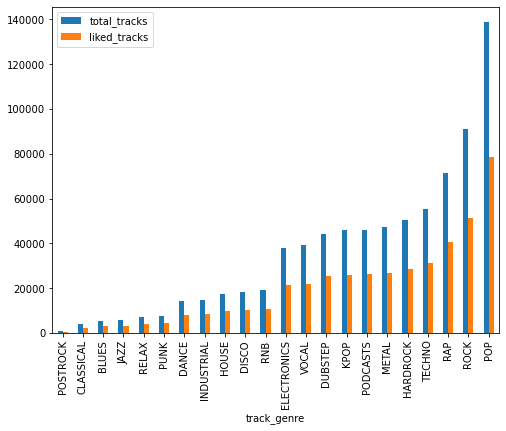

In [21]:
df_genres = df_new.groupby('track_genre').liked.agg(['count', 'sum'])
df_genres.rename(columns={'count': 'total_tracks', 'sum': 'liked_tracks'}, inplace=True)

df_genres.sort_values(by='total_tracks').plot(kind='bar', figsize=(8, 6))
plt.show()

Наиболее популярными жанрами являются поп, рок и рэп. Техно занимает почетное 4 место.

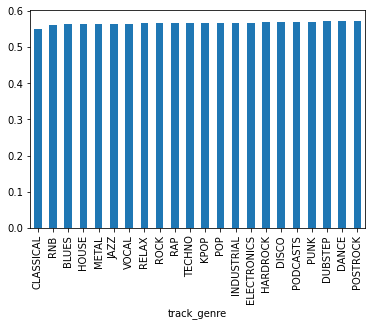

In [22]:
(df_genres['liked_tracks'] / df_genres['total_tracks']).sort_values().plot(kind='bar')
plt.show()

В среднем пользователям нравится около 60% треков независимо от жанра.

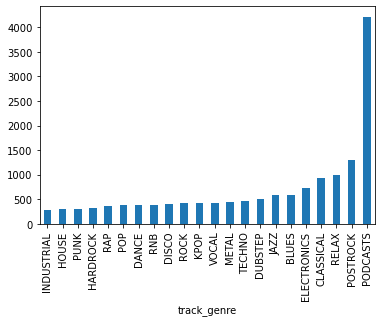

In [23]:
df.groupby('track_genre').track_duration.mean().sort_values().plot(kind='bar')
plt.show()

Из научного интереса посмотрим среднюю длину треков по жанрам и наконец-то перейдем к созданию метрик.

## Решение

Задачу можно сформулировать следующим образом: найти пользователей, которым нравится жанр техно. Для этого попробуем ввести некоторые количественные метрики.

### Метрика 1: доля понравившихся треков в жанре техно

Для начала посмотрим, какой процент прослушанных треков в жанре техно нравится пользователю.

In [24]:
df_techno = df_new.query('track_genre == "TECHNO"')
users = df_techno.groupby('user_id').liked.agg(['count', 'mean']).reset_index()
users.rename(columns={'count': 'techno_listened', 'mean': 'techno_liked'}, inplace=True)
users.sort_values(by='techno_liked', ascending=False, inplace=True)

In [25]:
df_new.user_id.nunique() - df_techno.user_id.nunique()

0

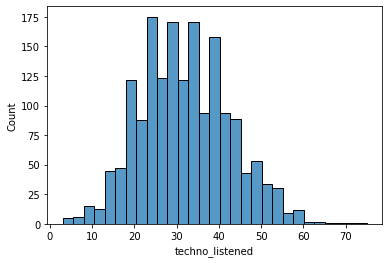

In [28]:
sns.histplot(data=users, x='techno_listened')
plt.show()

В среднем пользователь слушает 20-50 треков в жанре техно.

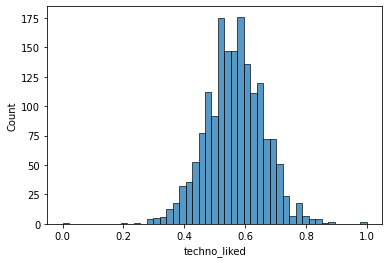

In [29]:
sns.histplot(data=users, x='techno_liked')
plt.show()

В среднем пользователю нравится около 60% прослушанных треков, что мы уже поняли ранее.

### Метрика 2: доля техно среди понравившихся

Теперь посмотрим, какой процент понравившихся пользователю песен приходится на техно. Если прошлая метрика показывала, насколько пользователю нравится жанр, то эта скорее говорит о "важности" жанра для пользователя.

In [30]:
# Оставим только понравившиеся песни
df_liked = df_new.query('liked == True')
df_liked.head()

,user_id,track_genre,listened,liked
3,b0a6dcec6f604b50b37e,HARDROCK,0.985269,True
4,6788b1c78a724de488c9,POP,0.830608,True
6,9769e98b78b449b384be,DUBSTEP,0.958672,True
9,5f8afde6e5fe4980b7cd,ROCK,0.914831,True
15,c9a4d16af97842a0b8e3,POP,0.900946,True


In [31]:
# Посчитаем количество песен каждого жанра по пользователям
df_liked_genres = pd.pivot_table(df_liked, index='user_id', columns='track_genre',
                                    values='liked', aggfunc='count')

df_liked_genres = df_liked_genres.fillna(0).astype(int)
df_liked_genres.head()

track_genre,BLUES,CLASSICAL,DANCE,DISCO,DUBSTEP,ELECTRONICS,HARDROCK,HOUSE,INDUSTRIAL,JAZZ,...,PODCASTS,POP,POSTROCK,PUNK,RAP,RELAX,RNB,ROCK,TECHNO,VOCAL
user_id,,,,,,,,,,,,,,,,,,,,,
002123faf66b47b5aafa,1,2,9,3,5,6,9,4,4,2,...,8,34,0,4,23,1,7,16,10,12
0041383820e248e487a6,5,5,11,9,42,19,29,12,10,3,...,39,108,0,6,54,5,16,59,39,26
008005a451764a63aa3f,5,1,6,10,22,14,21,3,7,0,...,20,66,2,2,41,4,4,37,22,17
00c017dc34254d39a390,1,1,6,10,20,25,15,7,10,2,...,19,59,0,4,25,3,8,43,33,15
00f628a2f8044ae18d88,1,1,5,5,7,8,14,3,5,1,...,19,44,1,2,18,1,8,25,22,7


In [32]:
liked_techno_share = df_liked_genres.TECHNO / df_liked_genres.sum(axis=1)
liked_techno_share = liked_techno_share.reset_index()
liked_techno_share.rename(columns={0: 'techno_share'}, inplace=True)
liked_techno_share.head()

,user_id,techno_share
0,002123faf66b47b5aafa,0.056180
1,0041383820e248e487a6,0.069892
2,008005a451764a63aa3f,0.065282
3,00c017dc34254d39a390,0.094017
4,00f628a2f8044ae18d88,0.097345


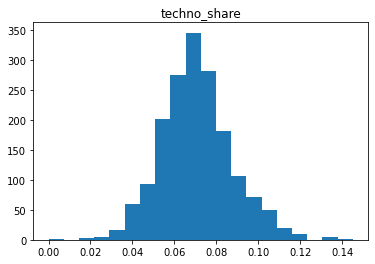

In [33]:
liked_techno_share.hist(bins=20, grid=False)
plt.show()

В среднем техно занимает 6-8% среди понравившихся пользователю треков.

In [34]:
users = users.merge(liked_techno_share, on='user_id')

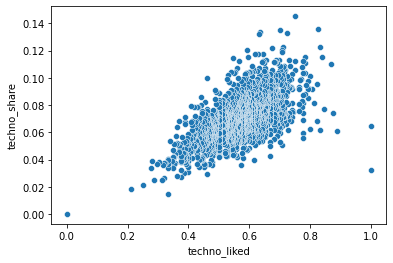

In [35]:
sns.scatterplot(data=users, x='techno_liked', y='techno_share')
plt.show()

Между первой и второй метрикой наблюдается положительная корреляция.

### Метрика 3: скоринг по техно

Недостатком первой метрики является то, что она игнорирует количество прослушанных песен. Можно попробовать ввести некоторую систему очков для оценки заинтересованности пользователя в жанре техно - начислять баллы за понравившиеся песни и снимать в обратном случае.

In [36]:
df_score = df_new

In [37]:
def score(x):
    if x <= 0.3:
        return -1  # вычитаем балл, если прослушано менее 30% песни
    elif x >= 0.7:
        return 1  # добавляем балл, если прослушано более 70% песни
    else:
        return 0

In [38]:
df_score['score'] = df_score.listened.apply(score)

In [39]:
user_scores = df_score.query('track_genre == "TECHNO"').groupby('user_id').score.sum().reset_index()
user_scores.head()

,user_id,score
0,002123faf66b47b5aafa,4
1,0041383820e248e487a6,17
2,008005a451764a63aa3f,9
3,00c017dc34254d39a390,23
4,00f628a2f8044ae18d88,15


In [40]:
users = users.merge(user_scores)
users.head()

,user_id,techno_listened,techno_liked,techno_share,score
0,aa770bfbbd544ef4948a,3,1.000000,0.032609,3
1,30bfa0fadeec4470aa4c,9,1.000000,0.064286,9
2,c7ad39e16a03419caff5,9,0.888889,0.060606,8
3,3c5ed26e27b0463eb81f,8,0.875000,0.074468,6
4,90b9479eba4349189878,23,0.869565,0.110497,19


### Метрика 4: скоринг по близким жанрам

Третью метрику можно немного изменить для оценки родственных жанров: электроника, танцевальная, хаус. На Яндекс Музыке они вынесены в одну группу, а у большинства техно-исполнителей в профиле указан именно такой набор музыкальных направлений. Можно предположить, что любителям техно нравится вышеуказанные жанры.

In [41]:
close_genres = ['TECHNO', 'ELECTRONICS', 'HOUSE', 'DANCE']
df_close = df_new.query('track_genre in @close_genres')
df_close.head()

,user_id,track_genre,listened,liked,score
8,3a66082e6a3941f591e1,ELECTRONICS,0.500405,False,0
14,20d9fc62bebb4f3c99b1,TECHNO,0.187383,False,-1
18,d8b0e8c218184184ad86,TECHNO,0.752797,True,1
23,bc44aaf2a590402684b7,TECHNO,0.165958,False,-1
26,88406b284c544698b48c,TECHNO,0.838832,True,1


In [42]:
df_close_score = pd.pivot_table(df_close, index='user_id', columns='track_genre', values='score', aggfunc='sum').fillna(0).astype(int)

In [43]:
df_close_score.corr()

track_genre,DANCE,ELECTRONICS,HOUSE,TECHNO
track_genre,,,,
DANCE,1.000000,0.074890,0.110495,0.149103
ELECTRONICS,0.074890,1.000000,0.106584,0.161018
HOUSE,0.110495,0.106584,1.000000,0.123531
TECHNO,0.149103,0.161018,0.123531,1.000000


Корреляция между жанрами очень низкая. Гипотеза опровергнута, поэтому смело отказываемся от этой метрики.

### Ранжирование пользователей по метрикам

Теперь, когда мы выделили несколько метрик, можно попытаться проранжировать пользователей от самых заинтересованных до тех, кого точно не стоит звать на фестиваль техно.

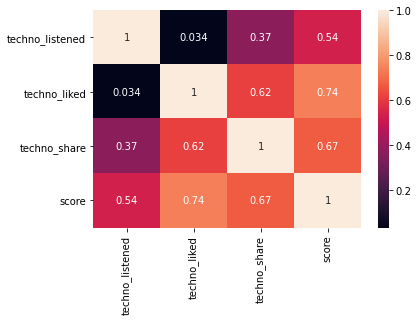

In [44]:
# между метриками есть положительные корреляции
sns.heatmap(users.corr(), annot=True)
plt.show()

In [45]:
# проранжируем пользователей
users.sort_values(by='techno_listened', ascending=False, inplace=True)
users['listened_rank'] = users.reset_index().index

users.sort_values(by='techno_liked', ascending=False, inplace=True)
users['liked_rank'] = users.reset_index().index

users.sort_values(by='techno_share', ascending=False, inplace=True)
users['share_rank'] = users.reset_index().index

users.sort_values(by='score', ascending=False, inplace=True)
users['score_rank'] = users.reset_index().index

users.head()

,user_id,techno_listened,techno_liked,techno_share,score,listened_rank,liked_rank,share_rank,score_rank
134,8232810d6053485db42b,63,0.698413,0.112821,33,5,134,22,0
437,43c91473008345efa8b0,67,0.626866,0.097674,32,3,437,119,1
154,11682c22c0584ede9314,58,0.689655,0.080972,31,16,152,411,2
24,825596f1cf1d4da7a957,46,0.782609,0.115016,30,173,23,17,3
217,bcec45de095c456ea61e,55,0.672727,0.092269,28,29,218,176,4


Мы получили ранг пользователя для каждой из метрик. Чем ранг меньше, тем больше мы уверены, что пользователь заинтересован в нашем предложении.

In [46]:
# просуммируем ранги
users['total_rank'] = users.iloc[:, -4:].sum(axis=1)
users.sort_values(by='total_rank', inplace=True)
users

,user_id,techno_listened,techno_liked,techno_share,score,listened_rank,liked_rank,share_rank,score_rank,total_rank
134,8232810d6053485db42b,63,0.698413,0.112821,33,5,134,22,0,161
92,4ccf7523ffe4420da841,52,0.711538,0.108187,28,69,92,39,6,206
24,825596f1cf1d4da7a957,46,0.782609,0.115016,30,173,23,17,3,216
62,79561be745b241f1bde6,48,0.729167,0.113269,27,144,62,20,7,233
59,75e1193d31af4e97bf44,52,0.730769,0.098701,28,72,58,108,5,243
...,...,...,...,...,...,...,...,...,...,...
1718,5687f9d340f7489fb565,16,0.312500,0.025253,-3,1628,1718,1721,1701,6768
1686,b34b034fcd924f9c8b5c,8,0.375000,0.027273,-2,1715,1683,1719,1695,6812
1721,1430742b4db2406d99a0,7,0.285714,0.024691,-1,1716,1721,1722,1668,6827
1724,caee2141602d4baf98de,12,0.250000,0.021429,-3,1690,1724,1723,1704,6841


Отлично, мы получили итоговый ранг для каждого пользователя. Однако стоит заметить, что переменная score несет информацию как о количестве прослушанных песен, так и о доле понравившихся. Поэтому ограничимся второй и третьей метриками.

In [47]:
users['total_rank2'] = users.share_rank + users.score_rank
users.sort_values(by='total_rank2', inplace=True)
users.head()

,user_id,techno_listened,techno_liked,techno_share,score,listened_rank,liked_rank,share_rank,score_rank,total_rank,total_rank2
24,825596f1cf1d4da7a957,46,0.782609,0.115016,30,173,23,17,3,216,20
134,8232810d6053485db42b,63,0.698413,0.112821,33,5,134,22,0,161,22
122,64b6c65c4129495ba6a7,50,0.700000,0.135135,24,98,122,2,21,243,23
62,79561be745b241f1bde6,48,0.729167,0.113269,27,144,62,20,7,233,27
160,7ad3d1dd2c1f4aef827a,48,0.687500,0.113402,26,133,159,19,10,321,29


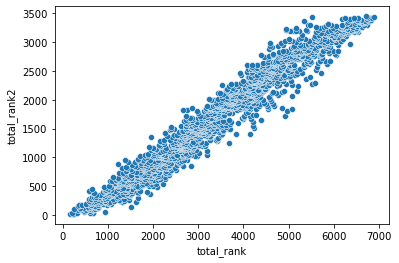

In [48]:
sns.scatterplot(data=users, x='total_rank', y='total_rank2')
plt.show()

Два итоговых ранга сильно коррелируют между собой, поэтому точность нашего предсказания в любом случае сильно не пострадает.

### Кого зовем?

Теперь, когда мы проранжировали пользователей и дали некоторую количественную оценку их заинтересованности, можно выбрать, кого звать на фестиваль.</br>
Предлагаю для начала выделить 10% пользователей из верха списка, получится около 170 человек, и разослать им приглашения. Цена одного письма составляет 10 рублей, поэтому суммарно придется заплатить всего 1700. Если конверсия будет удовлетворительной, можно продолжать рассылку.</br>
В противном случае, если итоговая метрика оказалось недостаточно точной, полученные данные об отклике можно использовать в качестве обучающей выборки для построения прогнозов.

In [49]:
users_to_offer = users[users.total_rank2 <= users.total_rank2.quantile(0.10)]

In [50]:
# Убедимся, что в выборку не попали выбросы
users_to_offer.describe().round(2)

,techno_listened,techno_liked,techno_share,score,listened_rank,liked_rank,share_rank,score_rank,total_rank,total_rank2
count,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00
mean,42.21,0.68,0.10,19.53,414.43,264.34,142.64,127.33,948.74,269.97
std,9.75,0.06,0.01,3.81,373.37,202.46,97.78,94.51,379.55,124.03
min,18.00,0.56,0.08,13.00,2.00,4.00,0.00,0.00,161.00,20.00
25%,36.00,0.64,0.09,17.00,104.00,106.00,62.00,48.00,669.00,176.00
50%,41.00,0.67,0.10,19.00,318.00,214.00,126.00,115.00,937.00,275.00
75%,50.00,0.71,0.10,22.00,601.00,372.00,204.00,191.00,1263.00,372.00
max,68.00,0.87,0.15,33.00,1571.00,890.00,445.00,412.00,1942.00,472.00


In [51]:
users_to_offer

,user_id,techno_listened,techno_liked,techno_share,score,listened_rank,liked_rank,share_rank,score_rank,total_rank,total_rank2
24,825596f1cf1d4da7a957,46,0.782609,0.115016,30,173,23,17,3,216,20
134,8232810d6053485db42b,63,0.698413,0.112821,33,5,134,22,0,161,22
122,64b6c65c4129495ba6a7,50,0.700000,0.135135,24,98,122,2,21,243,23
62,79561be745b241f1bde6,48,0.729167,0.113269,27,144,62,20,7,233,27
160,7ad3d1dd2c1f4aef827a,48,0.687500,0.113402,26,133,159,19,10,321,29
...,...,...,...,...,...,...,...,...,...,...,...
166,d328466a7c2c45d3b55c,32,0.687500,0.090909,15,807,162,197,265,1431,462
499,f33b4a064a074928aca4,39,0.615385,0.104803,13,431,500,53,412,1396,465
264,0311bed05d2b4c7a8ab9,44,0.659091,0.086053,17,217,265,288,182,952,470
500,6a13956d98a84849b8ac,39,0.615385,0.082192,19,449,496,371,100,1416,471
